# Random Forest Classification

@author: Florian Beyer

Version: 0.3

Datum: 2020-05-07

Classification using Random Forest

Updates: 
- generating a report.txt with all outputs
- using all cores to improve processing time


The script is based on the classification script of Chris Holden:
SOURCE: http://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html

additional things added/integrated:
- independend validation
- exception handling for memory error during the prediction part
- shape files as input (Julien Rebetez https://github.com/terrai/rastercube/blob/master/rastercube/datasources/shputils.py)
- report.txt


### Section - Required packages

In [62]:
# packages
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
from sklearn.ensemble import RandomForestClassifier # classifier
import pandas as pd # handling large data as table sheets
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix  # calculating measures for accuracy assessment
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import seaborn as sn

import datetime

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()


### Section - Input data

- This is the only section where you have to change something.

In [63]:

# define a number of trees that should be used (default = 500)
est = 800

# how many cores should be used?
# -1 -> all available cores
n_cores = -1

# the remote sensing image you want to classify
img_RS = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Ortho_Clipped_Test_v1.tif"


# training and validation as shape files
training = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Training.shp"
validation = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Validation.shp"

# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'id'


# directory, where the classification image should be saved:
classification_image = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Test 5\Ortho_classified_RS.tif"

# directory, where the all meta results should be saved:
results_txt = r"Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Test 5\Ortho_results.txt"

In [64]:
# laod training data and show all shape attributes

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

# extract the names of all attributes (fieldnames) in the shape file
attributes = []
ldefn = shape_layer.GetLayerDefn()
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    attributes.append(fdefn.name)
    
# print the attributes
print('Available attributes in the shape file are: {}'.format(attributes))

Available attributes in the shape file are: ['fid', 'id', 'layer', 'path']


### Section - Data preparation

In [65]:
# prepare results text file:

print('Random Forest Classification', file=open(results_txt, "a"))
print('Processing: {}'.format(datetime.datetime.now()), file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))
print('PATHS:', file=open(results_txt, "a"))
print('Image: {}'.format(img_RS), file=open(results_txt, "a"))
print('Training shape: {}'.format(training) , file=open(results_txt, "a"))
print('Vaildation shape: {}'.format(validation) , file=open(results_txt, "a"))
print('      choosen attribute: {}'.format(attribute) , file=open(results_txt, "a"))
print('Classification image: {}'.format(classification_image) , file=open(results_txt, "a"))
print('Report text file: {}'.format(results_txt) , file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))


In [66]:
# load image data

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()


In [67]:
row = img_ds.RasterYSize
col = img_ds.RasterXSize
band_number = img_ds.RasterCount

print('Image extent: {} x {} (row x col)'.format(row, col))
print('Number of Bands: {}'.format(band_number))


print('Image extent: {} x {} (row x col)'.format(row, col), file=open(results_txt, "a"))
print('Number of Bands: {}'.format(band_number), file=open(results_txt, "a"))
print('---------------------------------------', file=open(results_txt, "a"))
print('TRAINING', file=open(results_txt, "a"))
print('Number of Trees: {}'.format(est), file=open(results_txt, "a"))


Image extent: 5136 x 4682 (row x col)
Number of Bands: 4


In [68]:
# laod training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()



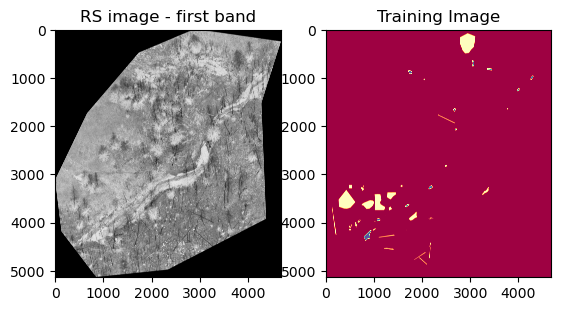

374401 training samples
training data include 2 classes: [1 2]
Our X matrix is sized: (374401, 4)
Our y array is sized: (374401,)


In [69]:
# Display images
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Image')

plt.show()

# Number of training pixels:
n_samples = (roi > 0).sum()
print('{n} training samples'.format(n=n_samples))
print('{n} training samples'.format(n=n_samples), file=open(results_txt, "a"))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels), file=open(results_txt, "a"))

# Subset the image dataset with the training image = X
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

### Section - Train Random Forest

In [70]:
rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=1, n_jobs=n_cores)



# verbose = 2 -> prints out every tree progression
# rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=2, n_jobs=n_cores)



X = np.nan_to_num(X)
rf2 = rf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   15.9s finished


### Section - RF Model Diagnostics

In [71]:
# With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:

print('--------------------------------', file=open(results_txt, "a"))
print('TRAINING and RF Model Diagnostics:', file=open(results_txt, "a"))
print('OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))
print('OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100), file=open(results_txt, "a"))


# we can show the band importance:
bands = range(1,img_ds.RasterCount+1)

for b, imp in zip(bands, rf2.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))
    print('Band {b} importance: {imp}'.format(b=b, imp=imp), file=open(results_txt, "a"))

    
# Let's look at a crosstabulation to see the class confusion. 
# To do so, we will import the Pandas library for some help:
# Setup a dataframe -- just like R
# Exception Handling because of possible Memory Error

try:
    df = pd.DataFrame()
    df['truth'] = y
    df['predict'] = rf.predict(X)

except MemoryError:
    print('Crosstab not available ')

else:
    # Cross-tabulate predictions
    print(pd.crosstab(df['truth'], df['predict'], margins=True))
    print(pd.crosstab(df['truth'], df['predict'], margins=True), file=open(results_txt, "a"))

OOB prediction of accuracy is: 91.81011802853091%
Band 1 importance: 0.42514116909532956
Band 2 importance: 0.299903997244052
Band 3 importance: 0.27495483366061846
Band 4 importance: 0.0


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    1.2s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    2.1s
[Parallel(n_jobs=32)]: Done 800 out of 800 | elapsed:    2.3s finished


predict       1      2     All
truth                         
1        324804   7954  332758
2         14485  27158   41643
All      339289  35112  374401


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    1.3s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    2.3s
[Parallel(n_jobs=32)]: Done 800 out of 800 | elapsed:    2.4s finished


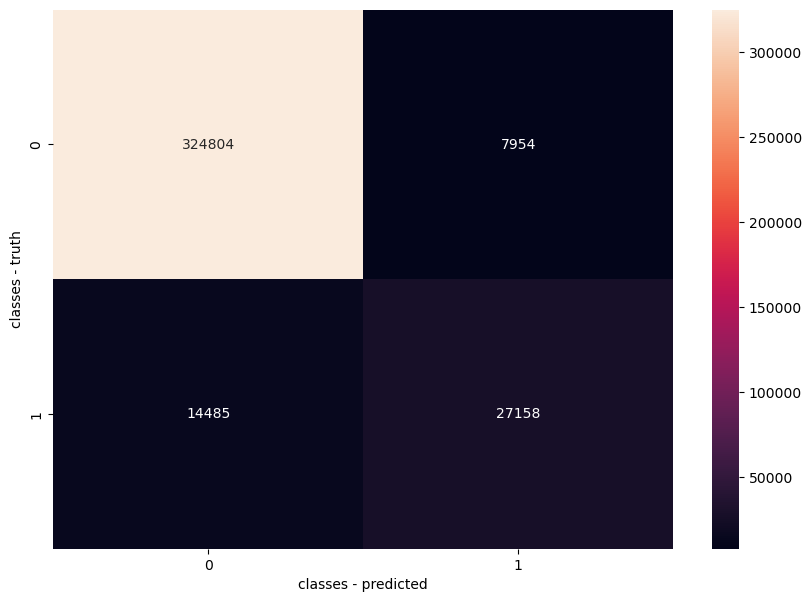

In [72]:
cm = confusion_matrix(y,rf.predict(X))
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='g')
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.show()

### Section - Prediction

In [73]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :int(img.shape[2])].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)


Reshaped from (5136, 4682, 4) to (24046752, 4)


In [74]:
# Now predict for each pixel
# first prediction will be tried on the entire image
# if not enough RAM, the dataset will be sliced
try:
    class_prediction = rf.predict(img_as_array)
except MemoryError:
    slices = int(round(len(img_as_array)/2))

    test = True
    
    while test == True:
        try:
            class_preds = list()
            
            temp = rf.predict(img_as_array[0:slices+1,:])
            class_preds.append(temp)
            
            for i in range(slices,len(img_as_array),slices):
                print('{} %, derzeit: {}'.format((i*100)/(len(img_as_array)), i))
                temp = rf.predict(img_as_array[i+1:i+(slices+1),:])                
                class_preds.append(temp)
            
        except MemoryError as error:
            slices = slices/2
            print('Not enought RAM, new slices = {}'.format(slices))
            
        else:
            test = False
else:
    print('Class prediction was successful without slicing!')

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   26.8s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:  1.2min
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:  2.3min
[Parallel(n_jobs=32)]: Done 800 out of 800 | elapsed:  2.4min finished


Class prediction was successful without slicing!


In [75]:
# concatenate all slices and re-shape it to the original extend
try:
    class_prediction = np.concatenate(class_preds,axis = 0)
except NameError:
    print('No slicing was necessary!')
    
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(class_prediction.shape))


No slicing was necessary!
Reshaped back to (5136, 4682)


### Section - Masking

- Mask classification image (black border = 0)


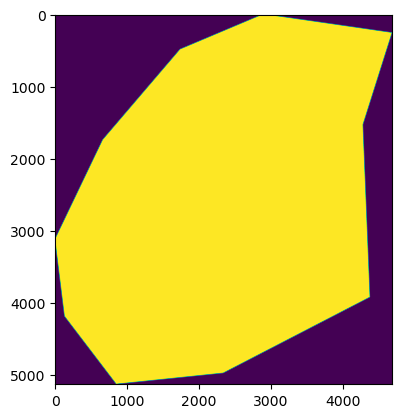

In [76]:
# generate mask image from red band
mask = np.copy(img[:,:,0])
mask[mask > 0.0] = 1.0 # all actual pixels have a value of 1.0

# plot mask

plt.imshow(mask)

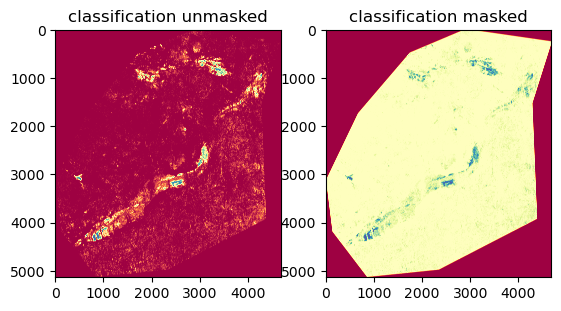

In [77]:
# mask classification an plot

class_prediction.astype(np.float16)
class_prediction_ = class_prediction*mask

plt.subplot(121)
plt.imshow(class_prediction, cmap=plt.cm.Spectral)
plt.title('classification unmasked')

plt.subplot(122)
plt.imshow(class_prediction_, cmap=plt.cm.Spectral)
plt.title('classification masked')

plt.show()

### Section - Saving Classification Image to disk

In [78]:
cols = img.shape[1]
rows = img.shape[0]

class_prediction_.astype(np.float16)
driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(classification_image, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(class_prediction_)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(classification_image))

Image saved to: Z:\ATD\Drone Data Processing\GIS Processing\Vegetation Filtering Test\Classification_Florian\Test_v1\Test 5\Ortho_classified_RS.tif


### Section - Accuracy Assessment

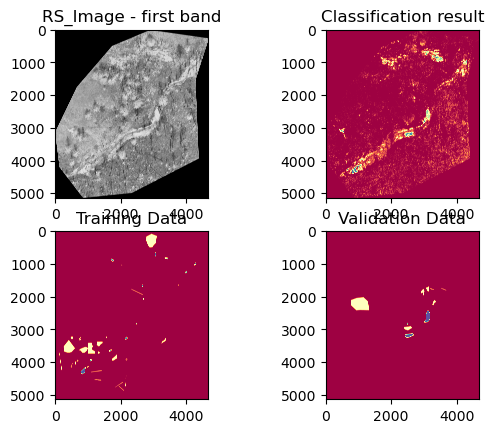

284538 validation pixels
validation data include 2 classes: [1 2]
Our X matrix is sized: (284538,)
Our y array is sized: (284538,)
col_0       1      2     All
row_0                       
1      224028   1535  225563
2       22746  36229   58975
All    246774  37764  284538
              precision    recall  f1-score   support

           1       0.91      0.99      0.95    225563
           2       0.96      0.61      0.75     58975

    accuracy                           0.91    284538
   macro avg       0.93      0.80      0.85    284538
weighted avg       0.92      0.91      0.91    284538

OAA = 91.46651765317813 %


In [79]:
# validation / accuracy assessment

# preparing ttxt file

print('------------------------------------', file=open(results_txt, "a"))
print('VALIDATION', file=open(results_txt, "a"))

# laod training data from shape file
shape_dataset_v = ogr.Open(validation)
shape_layer_v = shape_dataset_v.GetLayer()
mem_drv_v = gdal.GetDriverByName('MEM')
mem_raster_v = mem_drv_v.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster_v.SetProjection(img_ds.GetProjection())
mem_raster_v.SetGeoTransform(img_ds.GetGeoTransform())
mem_band_v = mem_raster_v.GetRasterBand(1)
mem_band_v.Fill(0)
mem_band_v.SetNoDataValue(0)

# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err_v = gdal.RasterizeLayer(mem_raster_v, [1], shape_layer_v, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err_v == gdal.CE_None

roi_v = mem_raster_v.ReadAsArray()



# vizualise
plt.subplot(221)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS_Image - first band')

plt.subplot(222)
plt.imshow(class_prediction, cmap=plt.cm.Spectral)
plt.title('Classification result')


plt.subplot(223)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Data')

plt.subplot(224)
plt.imshow(roi_v, cmap=plt.cm.Spectral)
plt.title('Validation Data')

plt.show()


# Find how many non-zero entries we have -- i.e. how many validation data samples?
n_val = (roi_v > 0).sum()
print('{n} validation pixels'.format(n=n_val))
print('{n} validation pixels'.format(n=n_val), file=open(results_txt, "a"))

# What are our validation labels?
labels_v = np.unique(roi_v[roi_v > 0])
print('validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v))
print('validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v), file=open(results_txt, "a"))
# Subset the classification image with the validation image = X
# Mask the classes on the validation dataset = y
# These will have n_samples rows
X_v = class_prediction[roi_v > 0]
y_v = roi_v[roi_v > 0]

print('Our X matrix is sized: {sz_v}'.format(sz_v=X_v.shape))
print('Our y array is sized: {sz_v}'.format(sz_v=y_v.shape))

# Cross-tabulate predictions
# confusion matrix
convolution_mat = pd.crosstab(y_v, X_v, margins=True)
print(convolution_mat)
print(convolution_mat, file=open(results_txt, "a"))
# if you want to save the confusion matrix as a CSV file:
#savename = 'C:\\save\\to\\folder\\conf_matrix_' + str(est) + '.csv'
#convolution_mat.to_csv(savename, sep=';', decimal = '.')

# information about precision, recall, f1_score, and support:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
#sklearn.metrics.precision_recall_fscore_support
target_names = list()
for name in range(1,(labels.size)+1):
    target_names.append(str(name))
sum_mat = classification_report(y_v,X_v,target_names=target_names)
print(sum_mat)
print(sum_mat, file=open(results_txt, "a"))

# Overall Accuracy (OAA)
print('OAA = {} %'.format(accuracy_score(y_v,X_v)*100))
print('OAA = {} %'.format(accuracy_score(y_v,X_v)*100), file=open(results_txt, "a"))

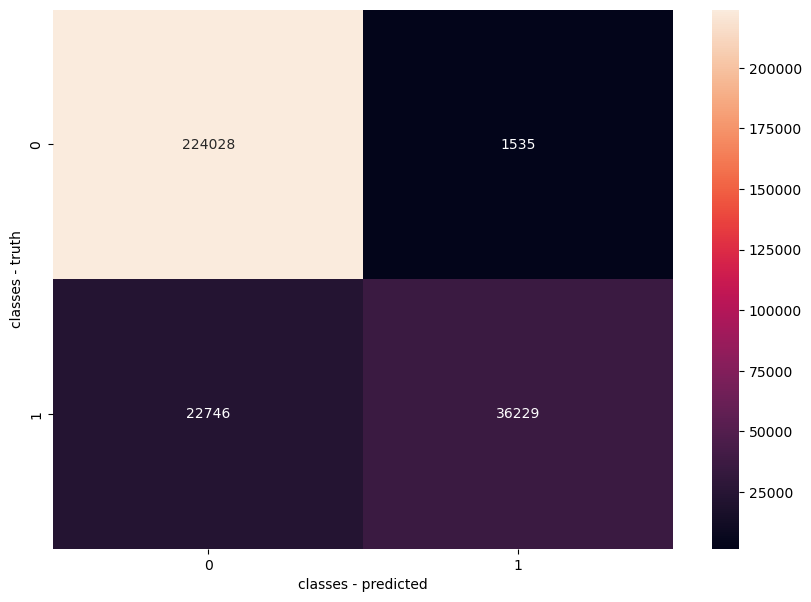

In [80]:
cm_val = confusion_matrix(roi_v[roi_v > 0],class_prediction[roi_v > 0])
plt.figure(figsize=(10,7))
sn.heatmap(cm_val, annot=True, fmt='g')
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.show()